# Session 3 - Closing Remarks Exercise: Multiclass XGBoost Classifier

In this notebook we will follow some of the same workflows we discussed across all sessions. For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument to test several data science techniques and machine learning algorithms. While this notebook does not require GPUs to run, we encourage you to modify this notebook to run using strickly cuML API functions.

Truth data was taken from the [MODIS Land Cover Type/Dynamics](https://modis.gsfc.nasa.gov/data/dataprod/mod12.php) dataset.

**Author**: Jordan A. Caraballo-Vega, Caleb S. Spradlin  
**Release Date**: 2023.04.06  
**Last Modified**: 2023.04.06  

## Prerequisites

Before running all cells in this notebook, you will need to enable the GPU runtime from Google Colab.

First, click Runtime in in the top toolbar:

![image](https://miro.medium.com/v2/resize:fit:500/format:webp/1*eAg8XGh4S8GjNRPE-0RgbQ.png)

Then, click Change runtime type:

![image](https://miro.medium.com/v2/resize:fit:300/format:webp/1*gZHTwaB6M3Z-z6JyLyy4-g.png)

select GPU for Hardware accelerator:

![image](https://miro.medium.com/v2/resize:fit:400/format:webp/1*ZrrmH8Li3ulBnpr3y4qw3A.png)

Once the GPU Runtime has been set, run the following Python code to check GPU type:

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.

In [ ]:
!wget https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py

--2023-05-04 12:20:44--  https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6189 (6.0K) [text/plain]
Saving to: ‘folium_helper.py.1’

folium_helper.py.1  100%[===================>]   6.04K  --.-KB/s    in 0s      

2023-05-04 12:20:44 (33.6 MB/s) - ‘folium_helper.py.1’ saved [6189/6189]



In [ ]:
!pip install datasets rasterio pyproj rioxarray shap lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import csv
import time
import glob
import joblib
import datasets
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

from huggingface_hub import snapshot_download

import mlxtend
import xarray as xr
import xgboost as xgb
import rioxarray as rxr

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# Explianability imports
import shap
import lime.lime_tabular as lime_tabular

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal
from osgeo import gdal_array

import folium
from folium import plugins
import folium_helper

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables
In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [ ]:
# directory where we will output figures
FIGURE_OUTPUT_DIR = 'output'

# directory where we will output raster
RASTER_OUTPUT_DIR = 'output'

# directory where we will output our models
MODEL_OUTPUT_DIR = 'models'

# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

# dataset filename

# small dataset
# DATASET_FILENAME = 'MODIS_multiclass_dataset.csv'

# larger dataset
DATASET_FILENAME = 'MODIS_multiclass_dataset_larger.csv'

# ratio of the dataset split for testing
TEST_RATIO = 0.2

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label, in our case this will be a categorical value
LABEL_NAME = 'label'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# columns used as features during training
v_names = ['b1','b2','b3',
           'b4','b5','b6',
           'b7','ndvi','ndwi1','ndwi2']

Here we create an output directory to store any artifacts out of our models and visualizations.

In [ ]:
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have uploaded a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:

- Read in data to a Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [ ]:
%%time
powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.csv", repo_type='dataset')
dataset_filename = os.path.join(powell_dataset, DATASET_FILENAME)
dataset_filename

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 26.1 ms, sys: 4.11 ms, total: 30.2 ms
Wall time: 69.4 ms


'/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/MODIS_multiclass_dataset_larger.csv'

Let's open the dataset into a pandas dataframe.

In [ ]:
dataset_df = pd.read_csv(dataset_filename, index_col=0)
dataset_df.head()

b1      b2      b3      b4      b5      b6      b7  label
0  0.2735  0.3784  0.0960  0.1569  0.4646  0.4943  0.4530    9.0
1  0.2791  0.3860  0.0919  0.1571  0.4716  0.4954  0.4611    9.0
2  0.2867  0.3897  0.1000  0.1672  0.4686  0.5068  0.4615    9.0
3  0.2878  0.3877  0.0980  0.1672  0.4785  0.5090  0.4700    9.0
4  0.2816  0.3772  0.0978  0.1673  0.4588  0.5008  0.4530    6.0

## 4. Exploratory Data Analysis (EDA)

Let's do some Exploratory Data Analysis to understand our data.

In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170000 entries, 0 to 169999
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   b1      170000 non-null  float64
 1   b2      170000 non-null  float64
 2   b3      170000 non-null  float64
 3   b4      170000 non-null  float64
 4   b5      170000 non-null  float64
 5   b6      170000 non-null  float64
 6   b7      170000 non-null  float64
 7   label   170000 non-null  float64
dtypes: float64(8)
memory usage: 11.7 MB


In this case the data type of all of our columns is float64, with a total of 170000 for the large dataset and 90524 rows (or observations) for the small dataset.

Pandas provides an excellent function to inspect the contents of our dataframes in a more concise way. Note the number of observations per feature, and the minimum and maximum values per MODIS band.

In [ ]:
dataset_df.describe().T

count      mean       std     min     25%     50%      75%      max
b1     170000.0  0.132061  0.142832  0.0126  0.0423  0.0651   0.2033   0.8270
b2     170000.0  0.231279  0.121006  0.0055  0.1647  0.1939   0.3075   0.7433
b3     170000.0  0.077826  0.115195 -0.0100  0.0221  0.0329   0.0856   0.7943
b4     170000.0  0.112679  0.127749  0.0189  0.0410  0.0593   0.1434   0.8270
b5     170000.0  0.255520  0.114085  0.0034  0.1951  0.2284   0.3097   0.7307
b6     170000.0  0.218949  0.143596  0.0061  0.1127  0.1853   0.2623   0.7479
b7     170000.0  0.153119  0.143184 -0.0009  0.0523  0.1008   0.1630   0.6433
label  170000.0  8.000000  4.898994  0.0000  4.0000  8.0000  12.0000  16.0000

array([[<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b2'}>,
        <Axes: title={'center': 'b3'}>],
       [<Axes: title={'center': 'b4'}>, <Axes: title={'center': 'b5'}>,
        <Axes: title={'center': 'b6'}>],
       [<Axes: title={'center': 'b7'}>,
        <Axes: title={'center': 'label'}>, <Axes: >]], dtype=object)

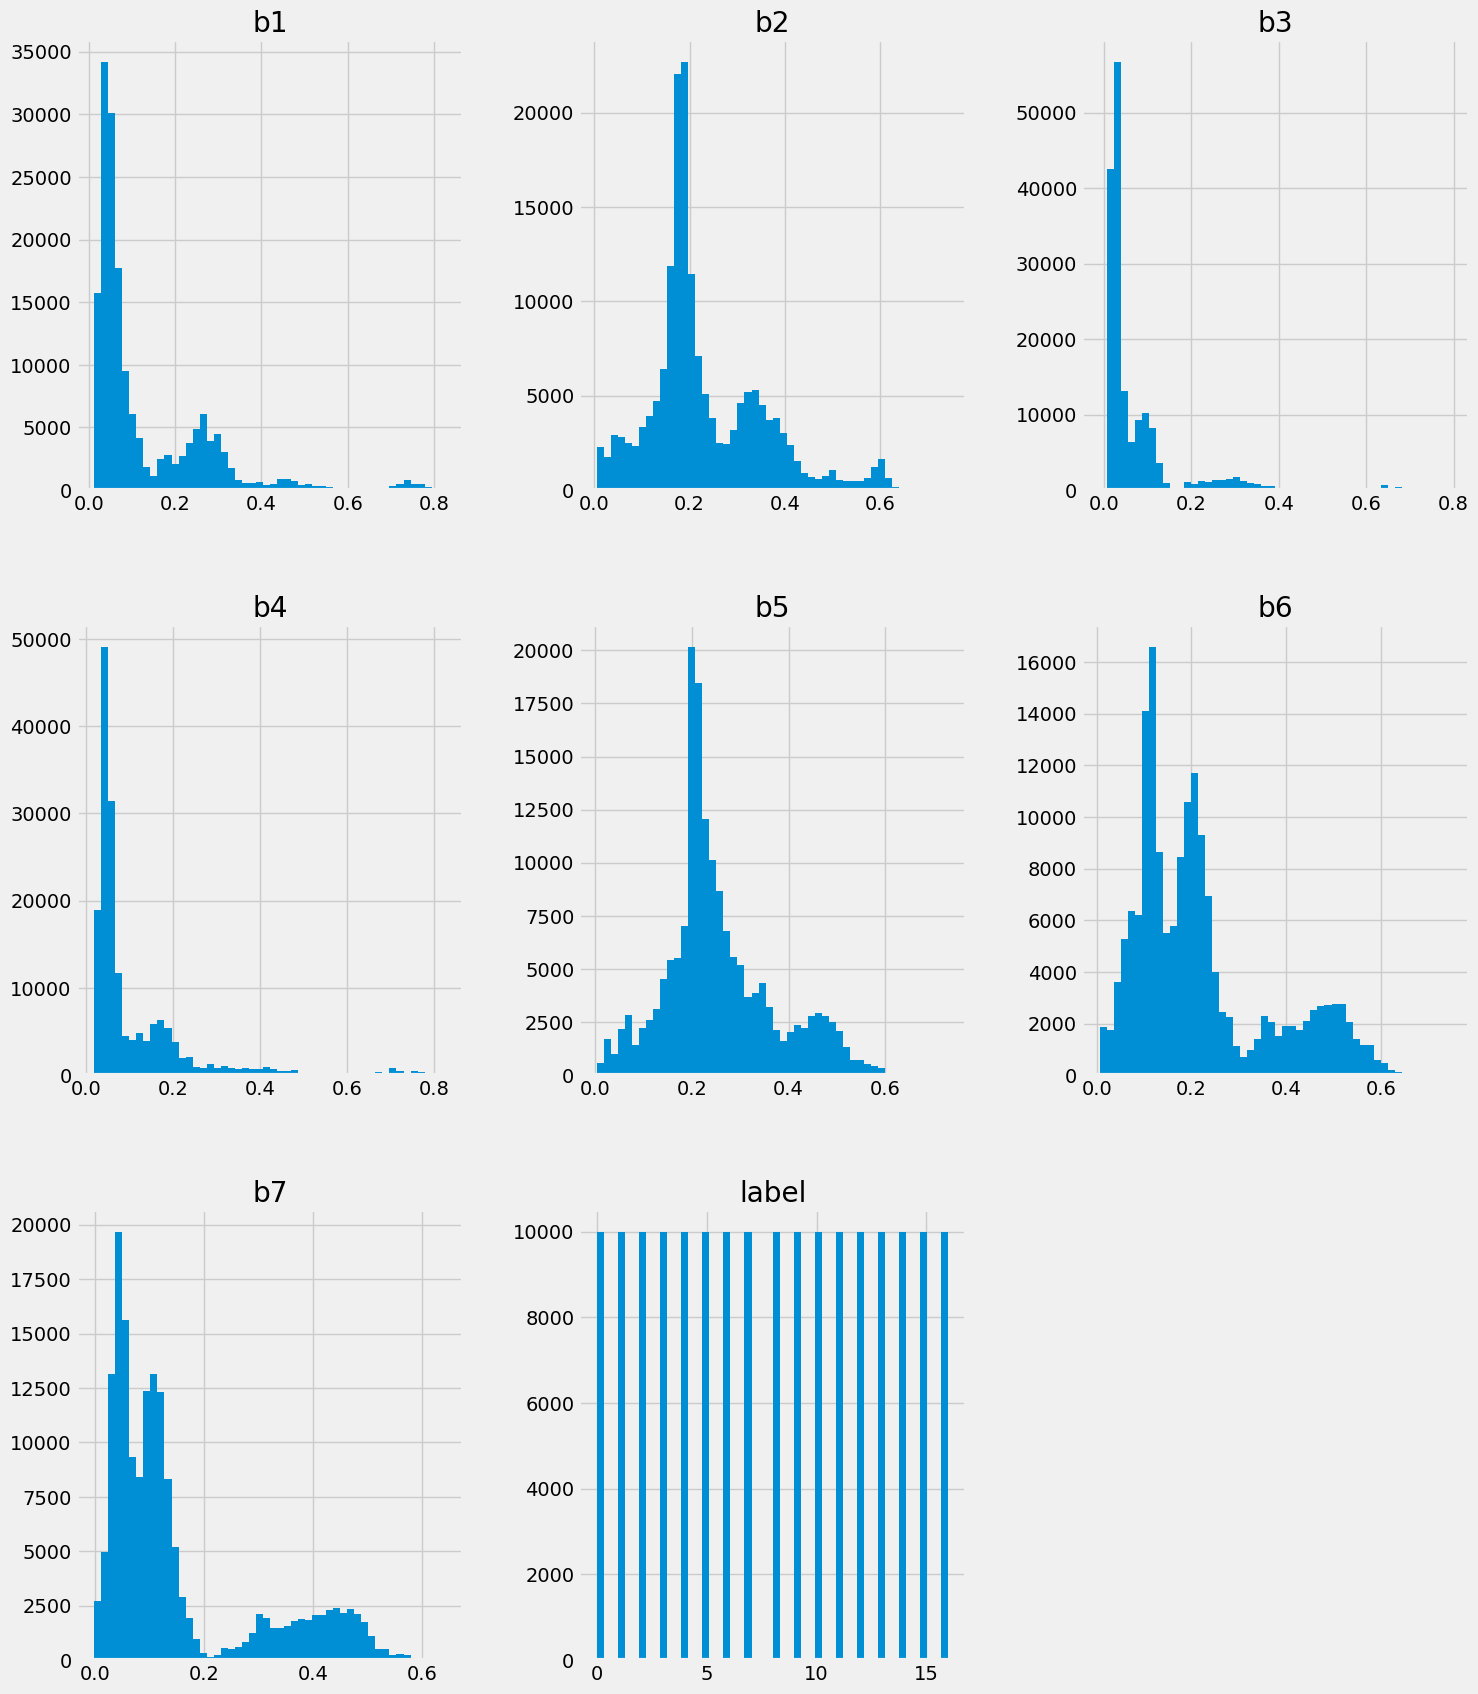

In [ ]:
dataset_df.hist(figsize=(16, 20), bins=50)

From this plot we can see how balanced is the distribution of our classes. The small dataset does not have class occurrences for class 14, and we have an extremely small number of occurrences for class 2. We need to take some decissions here.

If we feed this dataset to an XGBoost classifier, the classifier will fail because we do not have any occurrences for Class 14. Thus we will remove class 14 from our dataset since it belongs to 'Permanent Snow and Ice'. If our focus was to apply this model to locations with permanent snow and ice, then we would need to add samples from these to improve our training dataset.

For the large dataset, our classes are already balance, thus we can continnue to train our model.

{'Barren': 16, 'Closed Shrublands': 6, 'Cropland/Natural Vegetation Mosaics': 14, 'Croplands': 12, 'Deciduous Broadleaf Forests': 4, 'Deciduous Needleleaf Forests': 3, 'Evergreen Broadleaf Forests': 2, 'Evergreen Needleleaf Forests': 1, 'Grasslands': 10, 'long_name': 'Land_Cover_Type_1', 'Mixed Forests': 5, 'Open Shrublands': 7, 'Permanent Snow and Ice': 15, 'Permanent Wetlands': 11, 'Savannas': 9, 'Unclassified': 255, 'Urban and Built-up Lands': 13, 'Water Bodies': 17, 'Woody Savannas': 8}

In [ ]:
# Enable these options if you use the smaller dataset
# dataset_df['label'] = dataset_df['label'].replace([15, 16], [14, 15])
# dataset_df.head()

<Axes: >

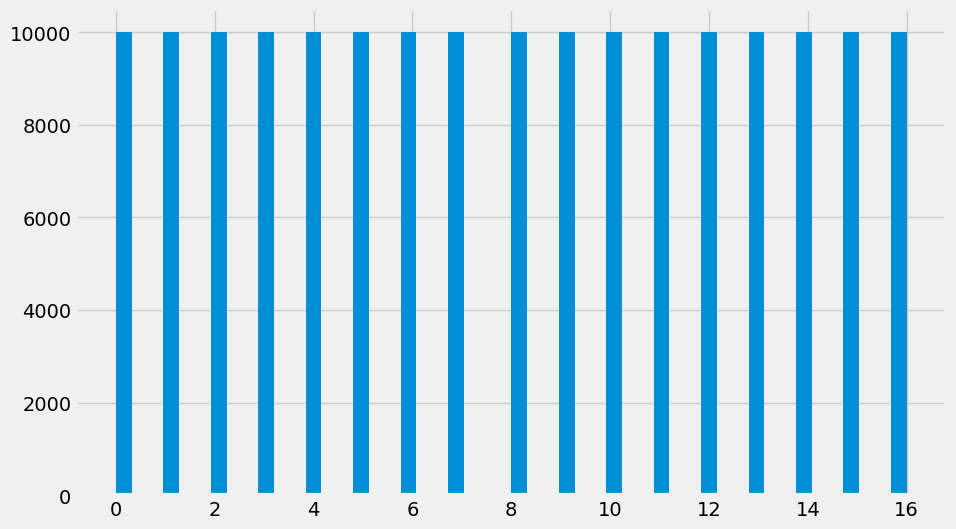

In [ ]:
dataset_df['label'].hist(figsize=(10, 6), bins=50)

Let's look at the new distributions:

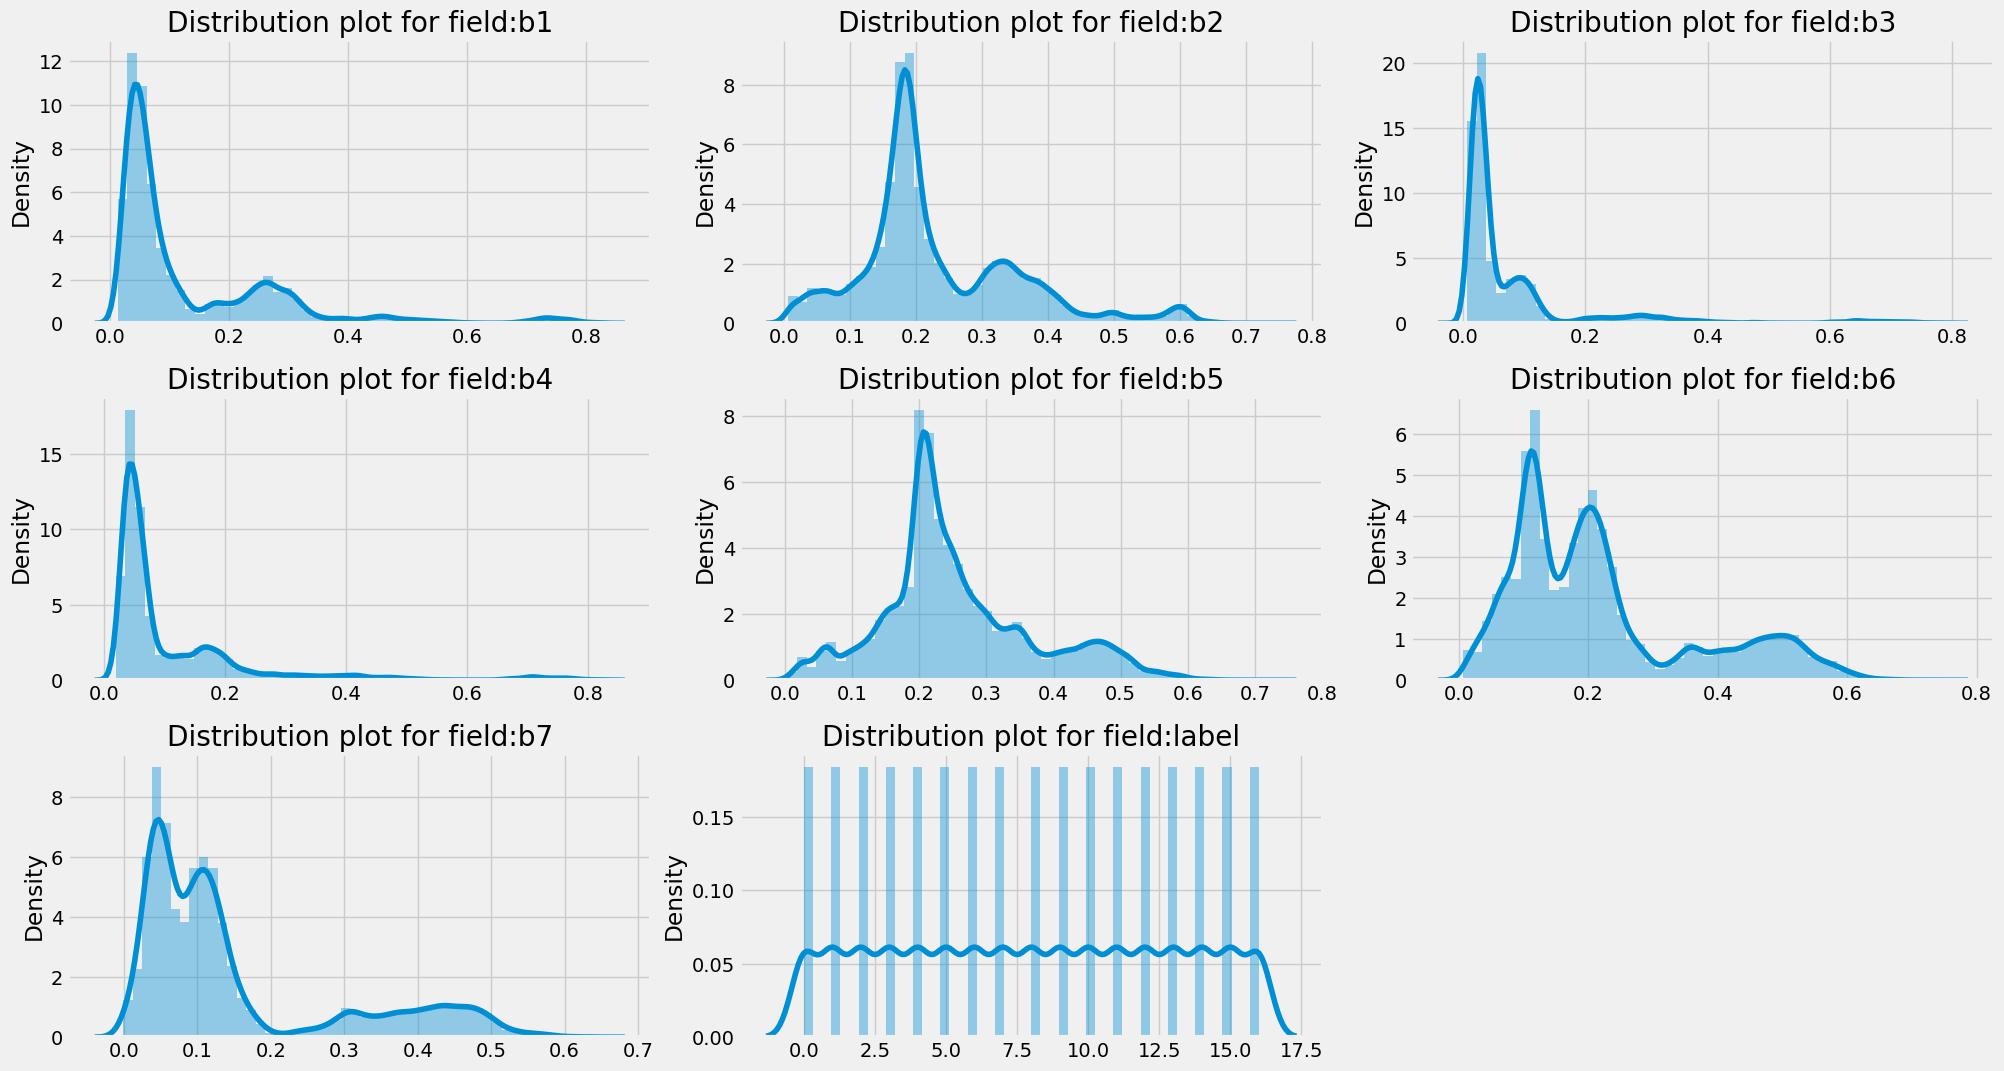

In [ ]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(dataset_df.select_dtypes(include='number').columns):
    plt.subplot(4,3,i+1)
    sns.distplot(dataset_df[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('output/output_dist_modis_water.png')

In [ ]:
dataset_df['label'].value_counts()

9.0     10000
10.0    10000
14.0    10000
13.0    10000
5.0     10000
11.0    10000
0.0     10000
16.0    10000
1.0     10000
6.0     10000
4.0     10000
3.0     10000
7.0     10000
8.0     10000
12.0    10000
15.0    10000
2.0     10000
Name: label, dtype: int64

## 5. Training Preparation

After we download our dataset, we proceed to split it into training and test set. Note how the label column is set as the y feature and is dropped from the X features.

We also need to convert the type of our labels to int for the model to run since it is a requirement from the XGBoost model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_df.drop(['label'], axis=1),
    dataset_df['label'].astype(DATA_TYPE),
    random_state=RANDOM_STATE,
    train_size=0.80,
)
X_train.shape, X_test.shape

((136000, 7), (34000, 7))

Once we have our training and test data ready, we proceed to prepare for training our model. One technique often used to better validate the robustness of a machine learning model is K-fold cross validation.

Cross-validation is a statistical method used to estimate the skill of machine learning models. When using k-fold, the dataset is split into ‘k’ number of subsets, k-1 subsets then are used to train the model and the last subset is kept as a validation set to test the model. Then the score of the model on each fold is averaged to evaluate the performance of the model.

sckit-learn provides a useful feature to quickly setup these experiments. A K of 10 has been described by literature as the most effective value to decrease variance and nominally test performance. In this example, we will use a value of K = 5 for time purposes.

In [ ]:
kf = KFold(n_splits=2) # increase the K for lower variance
kf.get_n_splits(X_train)

2

In [ ]:
_ = [print(column) for column in X_train.columns]

b1
b2
b3
b4
b5
b6
b7


## 6. Model definition and training

In this section we will define our model and train it using our dataset. The hyperparameters listed below are the default from the scikit-learn library, but these are usually very similar across other programming languages. Some of the most useful parameters to know about from the XGBoost are:
- n_estimators: number of trees in the forest
- max_depth: the maximum depth of a tree
- objective: it defines the loss function to be minimized. Most commonly used values are given below -
  - reg:squarederror : regression with squared loss.
  - reg:squaredlogerror: regression with squared log loss 1/2[log(pred+1)−log(label+1)]2. - All input labels are required to be greater than -1.
  - reg:logistic : logistic regression
  - binary:logistic : logistic regression for binary classification, output probability
  - binary:logitraw: logistic regression for binary classification, output score before logistic transformation
  - binary:hinge : hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
  - multi:softmax : set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)
  - multi:softprob : same as softmax, but output a vector of ndata nclass, which can be further reshaped to ndata nclass matrix. The result contains predicted probability of each data point belonging to each class.

In [ ]:
hyperparameters = {'objective': 'multi:softmax', #'binary:logistic', used for binary classification
                   'n_estimators':100,
                   'base_score': None,
                   'booster': None,
                   'colsample_bylevel': None,
                   'colsample_bynode': None,
                   'colsample_bytree': None,
                   'gamma': None,
                   'gpu_id': None,
                   'interaction_constraints': None,
                   'learning_rate': 0.003,
                   'max_delta_step': None,
                   'max_depth': None,
                   'min_child_weight': None,
                   'monotone_constraints': None,
                   'n_jobs': -1,
                   'num_parallel_tree': None,
                   'random_state': None,
                   'reg_alpha': None,
                   'reg_lambda': None,
                   'scale_pos_weight': None,
                   'subsample': None,
                   #'tree_method': '',
                   'validate_parameters': None,
                   'verbosity': None
}

Here we define the classifier by including the hyperparameters we defined above.

In [ ]:
classifier = xgb.XGBClassifier(**hyperparameters)

We can then define which metrics to use to monitor model performance during training.

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["merror", "mlogloss", "auc"]

## 6.1 k-Fold fitting

Then we can proceed to train our model using the k-Fold approach. We perform K iterations, and by the end of the iterations we select the best performing model, and calculate the average score across all of them.

In [ ]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [ 68000  68001  68002 ... 135997 135998 135999], Test [    0     1     2 ... 67997 67998 67999]
Fitting model
[0]	validation_0-merror:0.20613	validation_0-mlogloss:2.81621	validation_0-auc:0.98315	validation_1-merror:0.21053	validation_1-mlogloss:2.81624	validation_1-auc:0.98224
[1]	validation_0-merror:0.20234	validation_0-mlogloss:2.79950	validation_0-auc:0.98354	validation_1-merror:0.20721	validation_1-mlogloss:2.79956	validation_1-auc:0.98265
[2]	validation_0-merror:0.20186	validation_0-mlogloss:2.78312	validation_0-auc:0.98358	validation_1-merror:0.20665	validation_1-mlogloss:2.78323	validation_1-auc:0.98263
[3]	validation_0-merror:0.20199	validation_0-mlogloss:2.76707	validation_0-auc:0.98360	validation_1-merror:0.20653	validation_1-mlogloss:2.76721	validation_1-auc:0.98266
[4]	validation_0-merror:0.20221	validation_0-mlogloss:2.75131	validation_0-auc:0.98369	validation_1-merror:0.20732	validation_1-mlogloss:2.75149	validation_1-auc:0.98277
[5]	validation_0-merror:0.20137	va

Here we can calculate the average score, and the score of the best model.

In [ ]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.813875
Best accuracy score: 0.8148823529411765


### 6.2 Testing with additional features

Let's add NDVI, NDWI1, and NDWI2 to the dataset to see if there are any improvements on the performance of our model.

In [ ]:
dataset_df['ndvi'] = (dataset_df['b2'] - dataset_df['b1']) / (dataset_df['b2'] + dataset_df['b1'])
dataset_df['ndwi1'] = (dataset_df['b2'] - dataset_df['b6']) / (dataset_df['b2'] + dataset_df['b6'])
dataset_df['ndwi2'] = (dataset_df['b2'] - dataset_df['b7']) / (dataset_df['b2'] + dataset_df['b7'])
dataset_df

b1      b2      b3      b4      b5      b6      b7  label  \
0       0.2735  0.3784  0.0960  0.1569  0.4646  0.4943  0.4530    9.0   
1       0.2791  0.3860  0.0919  0.1571  0.4716  0.4954  0.4611    9.0   
2       0.2867  0.3897  0.1000  0.1672  0.4686  0.5068  0.4615    9.0   
3       0.2878  0.3877  0.0980  0.1672  0.4785  0.5090  0.4700    9.0   
4       0.2816  0.3772  0.0978  0.1673  0.4588  0.5008  0.4530    6.0   
...        ...     ...     ...     ...     ...     ...     ...    ...   
169995  0.0500  0.1709  0.0325  0.0483  0.1782  0.1187  0.0573    2.0   
169996  0.0409  0.1342  0.0204  0.0370  0.1608  0.1051  0.0583    2.0   
169997  0.0725  0.1834  0.0485  0.0693  0.2117  0.1461  0.0969    2.0   
169998  0.0369  0.1240  0.0164  0.0321  0.1490  0.0958  0.0509    2.0   
169999  0.0374  0.1281  0.0177  0.0339  0.1413  0.1020  0.0498    2.0   

            ndvi     ndwi1     ndwi2  
0       0.160914 -0.132806 -0.089728  
1       0.160728 -0.124121 -0.088655  
2       0.152277 -0.130619 -0.084351  
3       0.147890 -0.135274 -0.095954  
4       0.145112 -0.140775 -0.091303  
...          ...       ...       ...  
169995  0.547306  0.180249  0.497809  
169996  0.532838  0.121605  0.394286  
169997  0.433372  0.113202  0.308598  
169998  0.541330  0.128298  0.417953  
169999  0.548036  0.113429  0.440135  

[170000 rows x 11 columns]

Split the dataset one more time, this time including all of the features.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_df.drop(['label'], axis=1),
    dataset_df['label'].astype(DATA_TYPE),
    random_state=RANDOM_STATE,
    train_size=0.80,
)
X_train.shape, X_test.shape

((136000, 10), (34000, 10))

In [ ]:
classifier = xgb.XGBClassifier(**hyperparameters)

In [ ]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["merror", "mlogloss", "auc"]

In [ ]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [ 68000  68001  68002 ... 135997 135998 135999], Test [    0     1     2 ... 67997 67998 67999]
Fitting model
[0]	validation_0-merror:0.19480	validation_0-mlogloss:2.81566	validation_0-auc:0.98491	validation_1-merror:0.19829	validation_1-mlogloss:2.81571	validation_1-auc:0.98386
[1]	validation_0-merror:0.19460	validation_0-mlogloss:2.79847	validation_0-auc:0.98508	validation_1-merror:0.19809	validation_1-mlogloss:2.79857	validation_1-auc:0.98401
[2]	validation_0-merror:0.19213	validation_0-mlogloss:2.78163	validation_0-auc:0.98529	validation_1-merror:0.19588	validation_1-mlogloss:2.78178	validation_1-auc:0.98421
[3]	validation_0-merror:0.19071	validation_0-mlogloss:2.76513	validation_0-auc:0.98536	validation_1-merror:0.19426	validation_1-mlogloss:2.76532	validation_1-auc:0.98427
[4]	validation_0-merror:0.19037	validation_0-mlogloss:2.74892	validation_0-auc:0.98549	validation_1-merror:0.19382	validation_1-mlogloss:2.74916	validation_1-auc:0.98438
[5]	validation_0-merror:0.19032	va

In [ ]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.8222205882352941
Best accuracy score: 0.8224411764705882


Then we can simply compute the score from the model output. Note how we have some improvements in the performance of the model when we include additional features.

## 7. Model testing and training/testing data validation

Once we have trained our model we can proceed to use the best model and perform testing and validation using our dataset.

### 7.1 Get model metrics

We can calculate accuracy metrics from our model using the test dataset, but we can also output prediction probabilities to understand the drivers behind the model performance.

In [ ]:
classifier = bestModel

In [ ]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.823

Note how easy it is to perform predictions once we have datasets in dataframe format.

In [ ]:
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)
prediction_probs

array([[0.1171844 , 0.1025473 , 0.04918327, ..., 0.0491107 , 0.04909658,
        0.04913757],
       [0.04942524, 0.04941344, 0.04941354, ..., 0.04942716, 0.10351502,
        0.04945421],
       [0.04958097, 0.04956913, 0.04956922, ..., 0.04958289, 0.04956865,
        0.05048215],
       ...,
       [0.10315378, 0.10052564, 0.04864231, ..., 0.04857053, 0.04855658,
        0.04859711],
       [0.04852224, 0.04851066, 0.05211895, ..., 0.04852413, 0.04851019,
        0.06866693],
       [0.05061303, 0.05060094, 0.05060104, ..., 0.05061499, 0.05060046,
        0.0506427 ]], dtype=float32)

Here we can take the prediction probabilities straight out of the model so we can visualize them. These are important since they tell use the confidence of our model when perform the classification.

In [ ]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr.max())
predictionProbabilityArray = np.asarray(predictionProbabilityList)

### 7.2 Show the distribution of the probability of the predicted values.

These are the probability that each test data point is the given class. In binary problems, a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

In this multiclass problem we want the model to have higher probabilities since it will be an indicater of higher confidence when taking the decisions. Note that this is only from the models view, we need to do a deeper analysis with Explainable AI to know what triggers these decisions.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

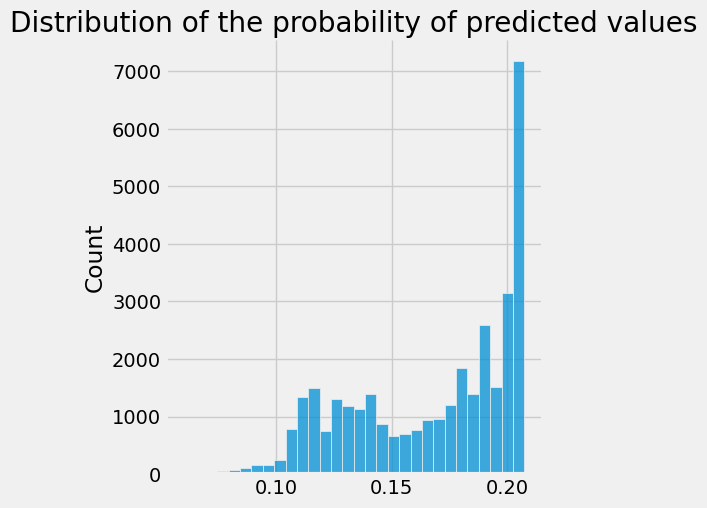

In [ ]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [ ]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

### 7.3 Additional Metrics

We can compute additional metrics to understand model performance related to producer and user accuracy.

In [ ]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test, test_predictions)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      2049
           1       0.56      0.40      0.47      1973
           2       0.96      0.97      0.97      2013
           3       0.74      0.84      0.79      1928
           4       0.50      0.54      0.52      2019
           5       0.91      0.98      0.94      2062
           6       0.87      0.86      0.87      1942
           7       0.60      0.62      0.61      1991
           8       0.79      0.74      0.76      1968
           9       0.87      0.85      0.86      1937
          10       0.91      0.85      0.88      2022
          11       0.93      0.93      0.93      2033
          12       0.91      0.94      0.93      2041
          13       0.96      0.88      0.92      2057
          14       1.00      1.00      1.00      2035
          15       0.91      0.93      0.92      1991
        

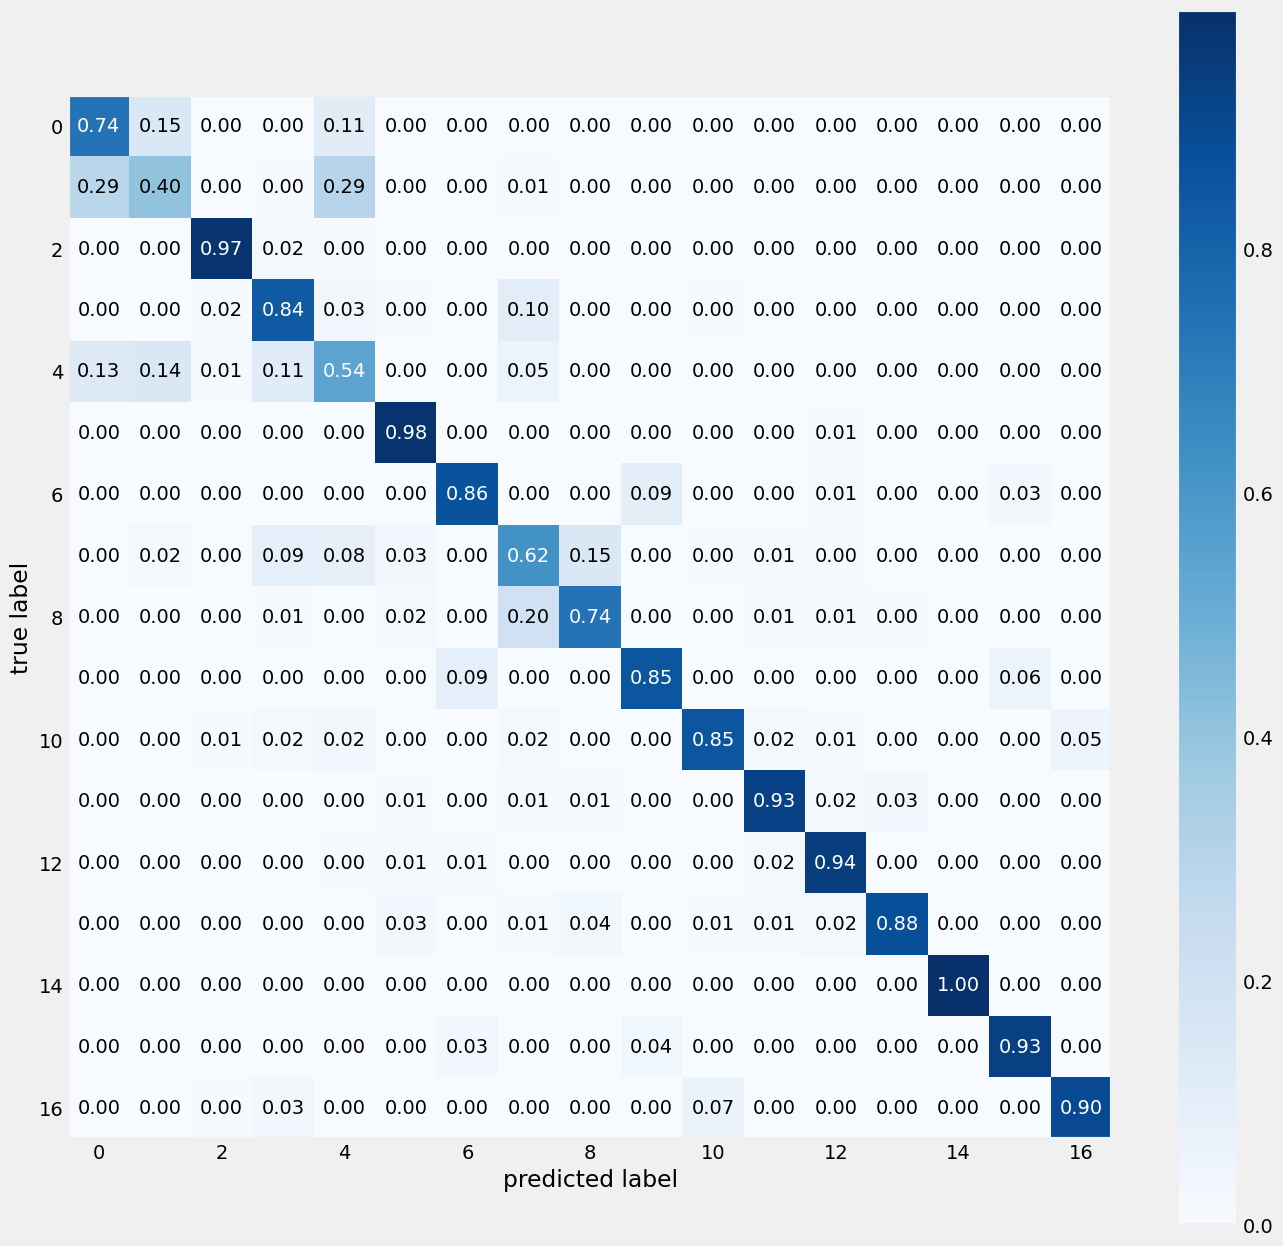

In [ ]:
class_names = [
    'Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests', 'Deciduous Needleleaf Forests',
    'Deciduous Broadleaf Forests', 'Mixed Forests', 'Closed Shrublands', 'Open Shrublands',
    'Woody Savannas', 'Savannas', 'Grasslands', 'Permanent Wetlands', 'Croplands', 'Urban and Built-up Lands',
    'Cropland/Natural Vegetation Mosaics', 'Permanent Snow and Ice', 'Barren', 'Water Bodies']

multiclass = confusion_matrix(y_test, test_predictions)

fig, ax = plot_confusion_matrix(conf_mat=multiclass, colorbar=True, show_absolute=False, show_normed=True, figsize=(15, 15))
ax.margins(2, 2)
plt.show()

We can also look at Receiver Operating Characteristic (ROC) plots to understand the performance of the model across all samples between True Positive and False Positive rates. The One-vs-the-Rest (OvR) multiclass strategy, also known as one-vs-all, consists in computing a ROC curve per each of the n_classes. In each step, a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk.

In [ ]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(34000, 17)

In [ ]:
label_binarizer.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int16)

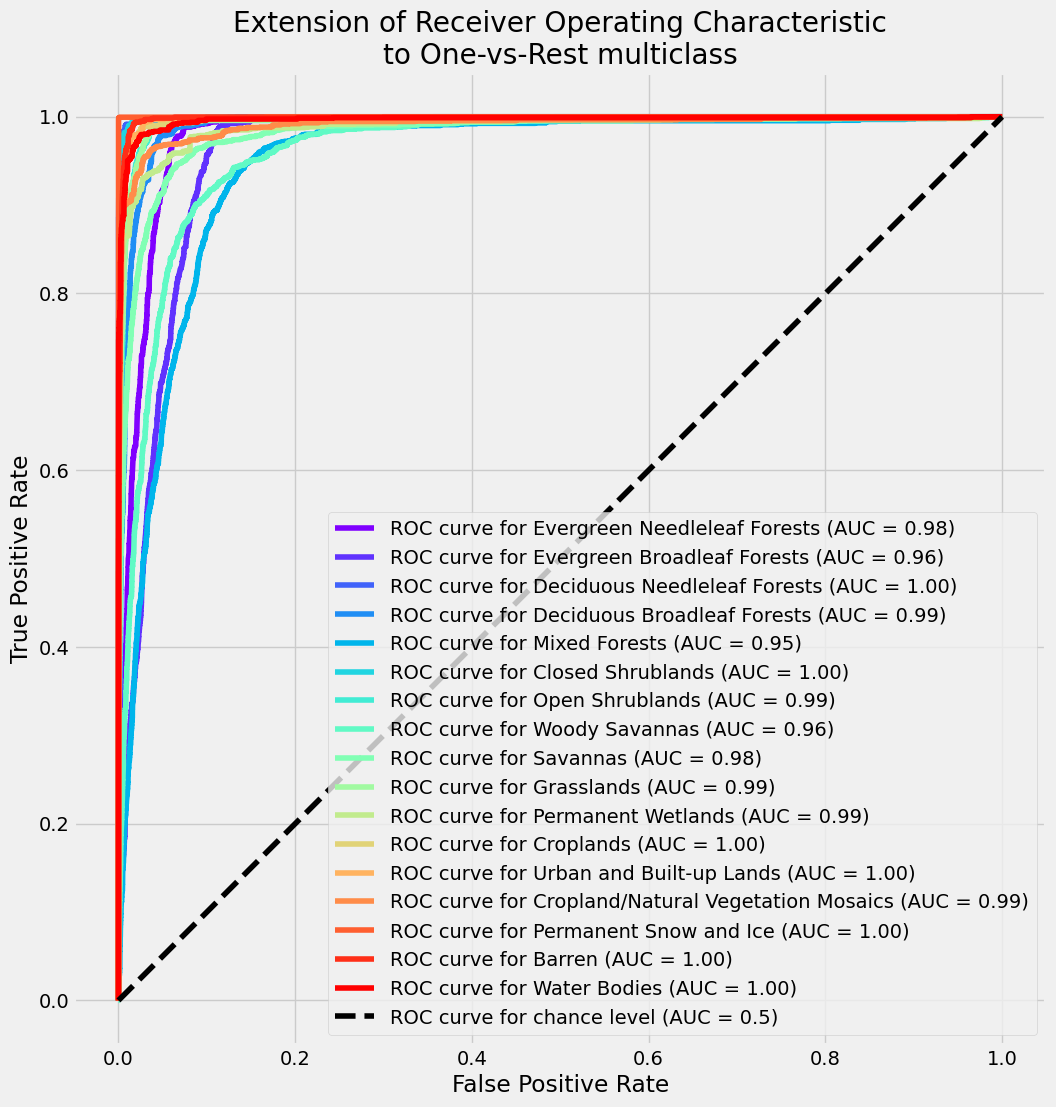

In [ ]:
from matplotlib.pyplot import cm
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

fig, ax = plt.subplots(figsize=(12, 12))
n_classes = len(class_names)

colors = cm.rainbow(np.linspace(0, 1, n_classes))
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        prediction_probs[:, class_id],
        name=f"ROC curve for {class_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

### 7.4 Permutation Importance

Another important metric to understand model performance is to evaluate permutation importance, particularly focused on the importance of each feature in the training and inference of the model.

In [ ]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 3min 11s, sys: 190 ms, total: 3min 11s
Wall time: 1min 51s


Let's look at some of the variables of most importance during the training and inference of the model.

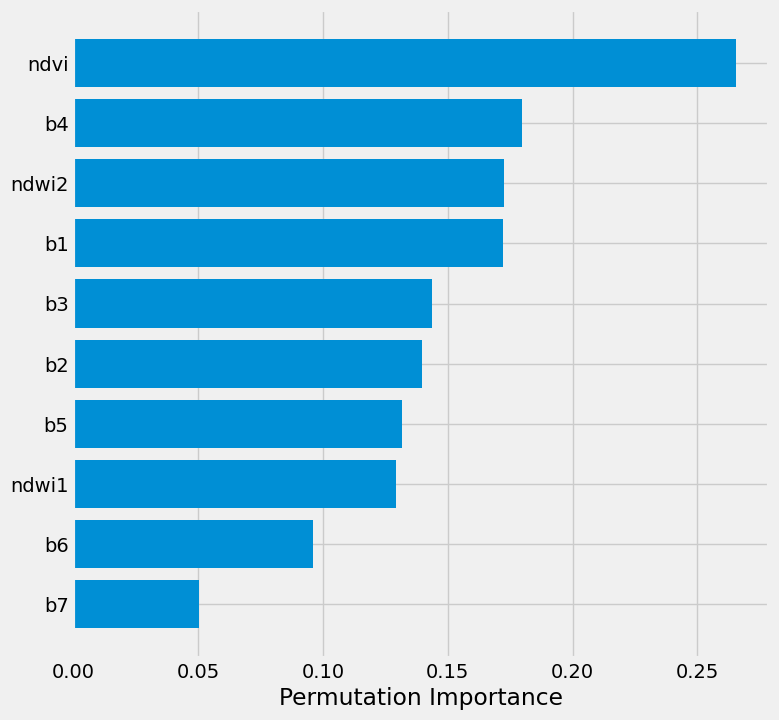

In [ ]:
png_save_path = 'mw_{}_{}_rf_{}_permutation_importance.png'.format(
    score,
    hyperparameters['n_estimators'],
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

## 8. Save the model for future use

We can then save our model for future use so we can apply it or share it elsewhere. The only prerequisite would be for the input dataset to be in the same format as the input training data.

In [ ]:
model_save_path = 'mw_{}_{}_{}_2.0.0_tuned_{}.sav'.format(score,
                                                             hyperparameters['n_estimators'],
                                                             'cpu',
                                                             datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: models/mw_0.823_100_cpu_2.0.0_tuned_2023_05_04_12_34.sav
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)


['models/mw_0.823_100_cpu_2.0.0_tuned_2023_05_04_12_34.sav']

## 9. Raster Inference

### 9.1 Data download

Here we can proceed to perform inference using raster objects. The first step is to download some imagery to test with.

In [ ]:
powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.tif", repo_type='dataset')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Then we can select all individual band TIF images and stack them to form the raster needed as input to the model. Note that you can skip this step if you already have your raster that includes all bands.

In [ ]:
fileList = sorted(glob.glob(os.path.join(powell_dataset, 'MOD09GA*.tif')))
fileList

['/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/MOD09GA.A2001155.h09v05.061.2020061221201.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/MOD09GA.A2006207.h18v03.061.2020267103537.tif',
 '/root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/MOD09GA.A2006218.h12v09.061.2020268185436.tif']

Then we can perform some feature engineering on the fly to add some additional column features such as NDVI, NDWI1, and NDWI2.

In [ ]:
def readRastersToArray(raster_filename):
    """
    Here we read and reproject the tiles, then do some feature
    engineering to calculate individual indices
    """
    raster = rxr.open_rasterio(raster_filename, mask_and_scale=True)
    raster = raster.rio.reproject("EPSG:3857")
    print(raster.shape)

    n_bands = raster.shape[0]

    ndvi = (((raster[1, :, :] - raster[0, :, :]) / (raster[1, :, :] + raster[0, :, :]))).expand_dims(dim="band", axis=0)
    ndvi.coords['band'] = [n_bands + 1]

    ndwi1 = (((raster[1, :, :] - raster[5, :, :]) / (raster[1, :, :] + raster[5, :, :]))).expand_dims(dim="band", axis=0)
    ndwi1.coords['band'] = [n_bands + 2]

    ndwi2 = (((raster[1, :, :] - raster[6, :, :]) / (raster[1, :, :] + raster[6, :, :]))).expand_dims(dim="band", axis=0)
    ndwi2.coords['band'] = [n_bands + 3]
    return xr.concat([raster, ndvi, ndwi1, ndwi2], dim='band')

def predictRaster(dataframe, colsToDrop=None):
    """
    Function given a raster in the form of a
    GPU/CPU-bound data frame then perform
    predictions given the loaded model.

    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = dataframe.drop(columns=colsToDrop) if colsToDrop else dataframe
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs

def save_raster(filename, predicted_raster, output_filename, prediction_nodata=255, epsg="EPSG:3857"):
    """
    Here we take the output from the model
    and save it into GTiff format
    """
    if predicted_raster.dtype == 'float32':
      prediction_nodata = -9999

    # open raster object
    raster_obj = rxr.open_rasterio(filename)
    raster_obj = raster_obj.rio.reproject(epsg).fillna(-9999)
    raster_obj.attrs['_FillValue'] = -9999
    raster_array = raster_obj.values

    # Drop raster band to allow for a merge of mask
    raster_obj = raster_obj.drop(
        dim="band",
        labels=raster_obj.coords["band"].values[1:],
    )
    predicted_raster[raster_array[0, :, :] == -9999] = prediction_nodata

    # Get metadata to save raster
    prediction = xr.DataArray(
        np.expand_dims(predicted_raster, axis=0),
        name='output',
        coords=raster_obj.coords,
        dims=raster_obj.dims,
        attrs=raster_obj.attrs
    ).fillna(prediction_nodata)
    prediction.attrs['_FillValue'] = prediction_nodata

    # Add metadata to raster attributes
    prediction.attrs['long_name'] = ('output')

    # Set nodata values on mask
    nodata = prediction.rio.nodata
    prediction.rio.write_nodata(
        prediction_nodata, encoded=True, inplace=True)

    # Save output raster file to disk
    prediction.rio.to_raster(
        output_filename,
        BIGTIFF="IF_SAFER",
        compress='LZW',
        driver='GTiff',
        dtype='int16'
    )
    return

### 9.2 Perform Inference

We can then iterate over each raster we want to predict and output the predictions and probabilities into a single GTiff.

In [ ]:
%%time

# iterate over each filename
for filename in fileList:

  print("Filename: ", filename)

  # read raster into array
  raster_array = readRastersToArray(filename).values
  print("Input raster shape: ", raster_array.shape)

  # flatten the raster for prediction
  flatten_raster = raster_array.reshape((raster_array.shape[0], raster_array.shape[1]*raster_array.shape[2])).transpose()
  flatten_raster[np.isnan(flatten_raster)] = 0
  print("Flatten raster shape: ", flatten_raster.shape)

  # perform prediction, and reshape raster and probabilities
  predicted_raster, predicted_probability = predictRaster(flatten_raster)
  predicted_raster = predicted_raster.reshape((raster_array.shape[1], raster_array.shape[2]))
  predicted_probability = predicted_probability[:, 1].reshape((raster_array.shape[1], raster_array.shape[2]))
  print("Output predictions shape: ", predicted_raster.shape, predicted_probability.shape)

  # saved output into raster
  save_raster(filename, predicted_raster, f'{Path(filename).stem}-prediction.tif')
  save_raster(filename, predicted_probability, f'{Path(filename).stem}-probability.tif')



Filename:  /root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/MOD09GA.A2001155.h09v05.061.2020061221201.tif
(7, 1487, 3051)
Input raster shape:  (10, 1487, 3051)
Flatten raster shape:  (4536837, 10)
Making predictions from raster
Output predictions shape:  (1487, 3051) (1487, 3051)
Filename:  /root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/MOD09GA.A2006207.h18v03.061.2020267103537.tif
(7, 2540, 2895)
Input raster shape:  (10, 2540, 2895)
Flatten raster shape:  (7353300, 10)
Making predictions from raster
Output predictions shape:  (2540, 2895) (2540, 2895)
Filename:  /root/.cache/huggingface/hub/datasets--nasa-cisto-data-science-group--modis-lake-powell-toy-dataset/snapshots/e22fb0ce2c73d603ff182183fbfc1476d0032d1d/MOD09GA.A2006218.h12v09.061.2020268185436.tif
(7, 2500, 2718)
Input rast

## 10. Visualize your output

We can then proceed to visualize the output of our model in an interactive map. But first, we need to fix the projection in order to properly display the map using the interactive visualization package called folium.

In [ ]:
predicted_filenames = sorted(glob.glob('*prediction.tif'))
predicted_probability_filenames = sorted(glob.glob('*probability.tif'))
predicted_filenames

['MOD09GA.A2001155.h09v05.061.2020061221201-prediction.tif',
 'MOD09GA.A2006207.h18v03.061.2020267103537-prediction.tif',
 'MOD09GA.A2006218.h12v09.061.2020268185436-prediction.tif']

Define color mapping values:

In [ ]:
colors = [
    (140, 219, 255),
    (38, 115, 0),
    (82, 204, 77),
    (150, 196, 20),
    (122, 250, 166),
    (137, 205, 102),
    (215, 158, 158),
    (255, 240, 196),
    (233, 255, 190),
    (255, 216, 20),
    (255, 196, 120),
    (0, 132, 168),
    (255, 255, 115),
    (255, 0, 0),
    (168, 168, 0),
    (255, 255, 255),
    (130, 130, 130),
    (0, 0, 0)
]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int16), array([    710,    7388,   10421,    1859,    8383,   75580,  423986,
         25085,  221055,  319364,    6521,  175605,  386513,  236487,
        216667,   61123,   37242, 2322848]))


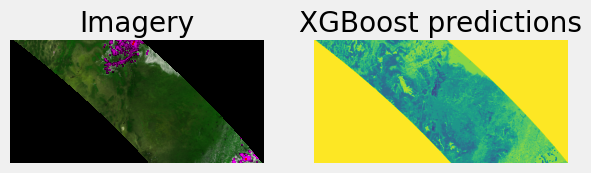

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int16), array([ 131510,  321377,  119963,    3368,   80531,   48494,   13446,
         24908,  111458,    4735,  959003,  302755,  443129, 1558604,
        233118,    8436, 2120079,  868386]))


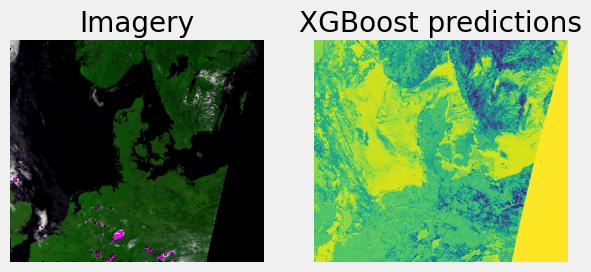

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int16), array([ 246962,   68129,   61044,     926,   25768,    5933,     445,
         18215,  229071,     128,   78071,   51094,   83407, 5255147,
         44764,     330,   80981,  544585]))


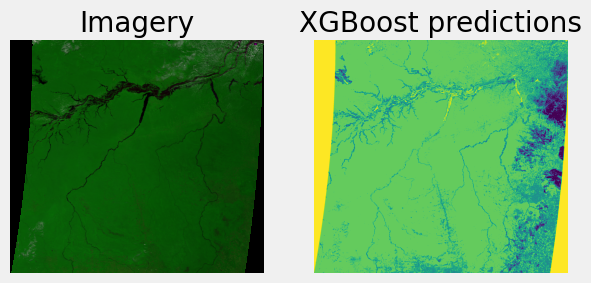

In [ ]:
for data_filename, predicted_filename in zip(fileList, predicted_filenames):

    data = rxr.open_rasterio(data_filename).rio.reproject("EPSG:3857")
    data = np.moveaxis(data[:3,:,:].values, 0, -1)

    mask = np.squeeze(rxr.open_rasterio(predicted_filename).values)
    mask[mask == 255] = 17
    print(np.unique(mask, return_counts=True))

    # plot the imagery and the prediction mask for comparison
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(data / 10000)
    axarr[0].set_title('Imagery')
    axarr[1].imshow(mask)
    axarr[1].set_title('XGBoost predictions')

    axarr[0].axis('off')
    axarr[1].axis('off')

    plt.show()

Define the folium map for visualization:

In [ ]:
m = folium.Map(tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 10, attr='Google')

Then iterate over each output prediction and add it as a layer to our map.

In [ ]:
for filename in predicted_filenames:
    mask_3857 = folium_helper.reproject_to_3857(filename)
    mask_d = folium_helper.get_bounds(mask_3857)
    mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
    mask_b1[mask_b1 == 255] = 17
    print(mask_b1.shape)
    folium_helper.cleanup(mask_3857)
    print("Unique values in mask: ", np.unique(mask_b1))

    m.add_child(
        folium.raster_layers.ImageOverlay(
            mask_b1, bounds=mask_d['bounds'],
            opacity=1, colormap=lambda x: colors[x])
    )

Transform: | 916.18, 0.00,-13078554.72|
| 0.00,-916.18, 4865942.28|
| 0.00, 0.00, 1.00|
Width: 3051 Height: 1487
(1487, 3051)
Unique values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Transform: | 769.16, 0.00,-0.00|
| 0.00,-769.16, 8399737.89|
| 0.00, 0.00, 1.00|
Width: 2895 Height: 2540
(2540, 2895)
Unique values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Transform: | 447.54, 0.00,-6782206.40|
| 0.00,-447.54, 0.00|
| 0.00, 0.00, 1.00|
Width: 2718 Height: 2500
(2500, 2718)
Unique values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


From there we can define a basemap and the region of interest for our map to initially start.


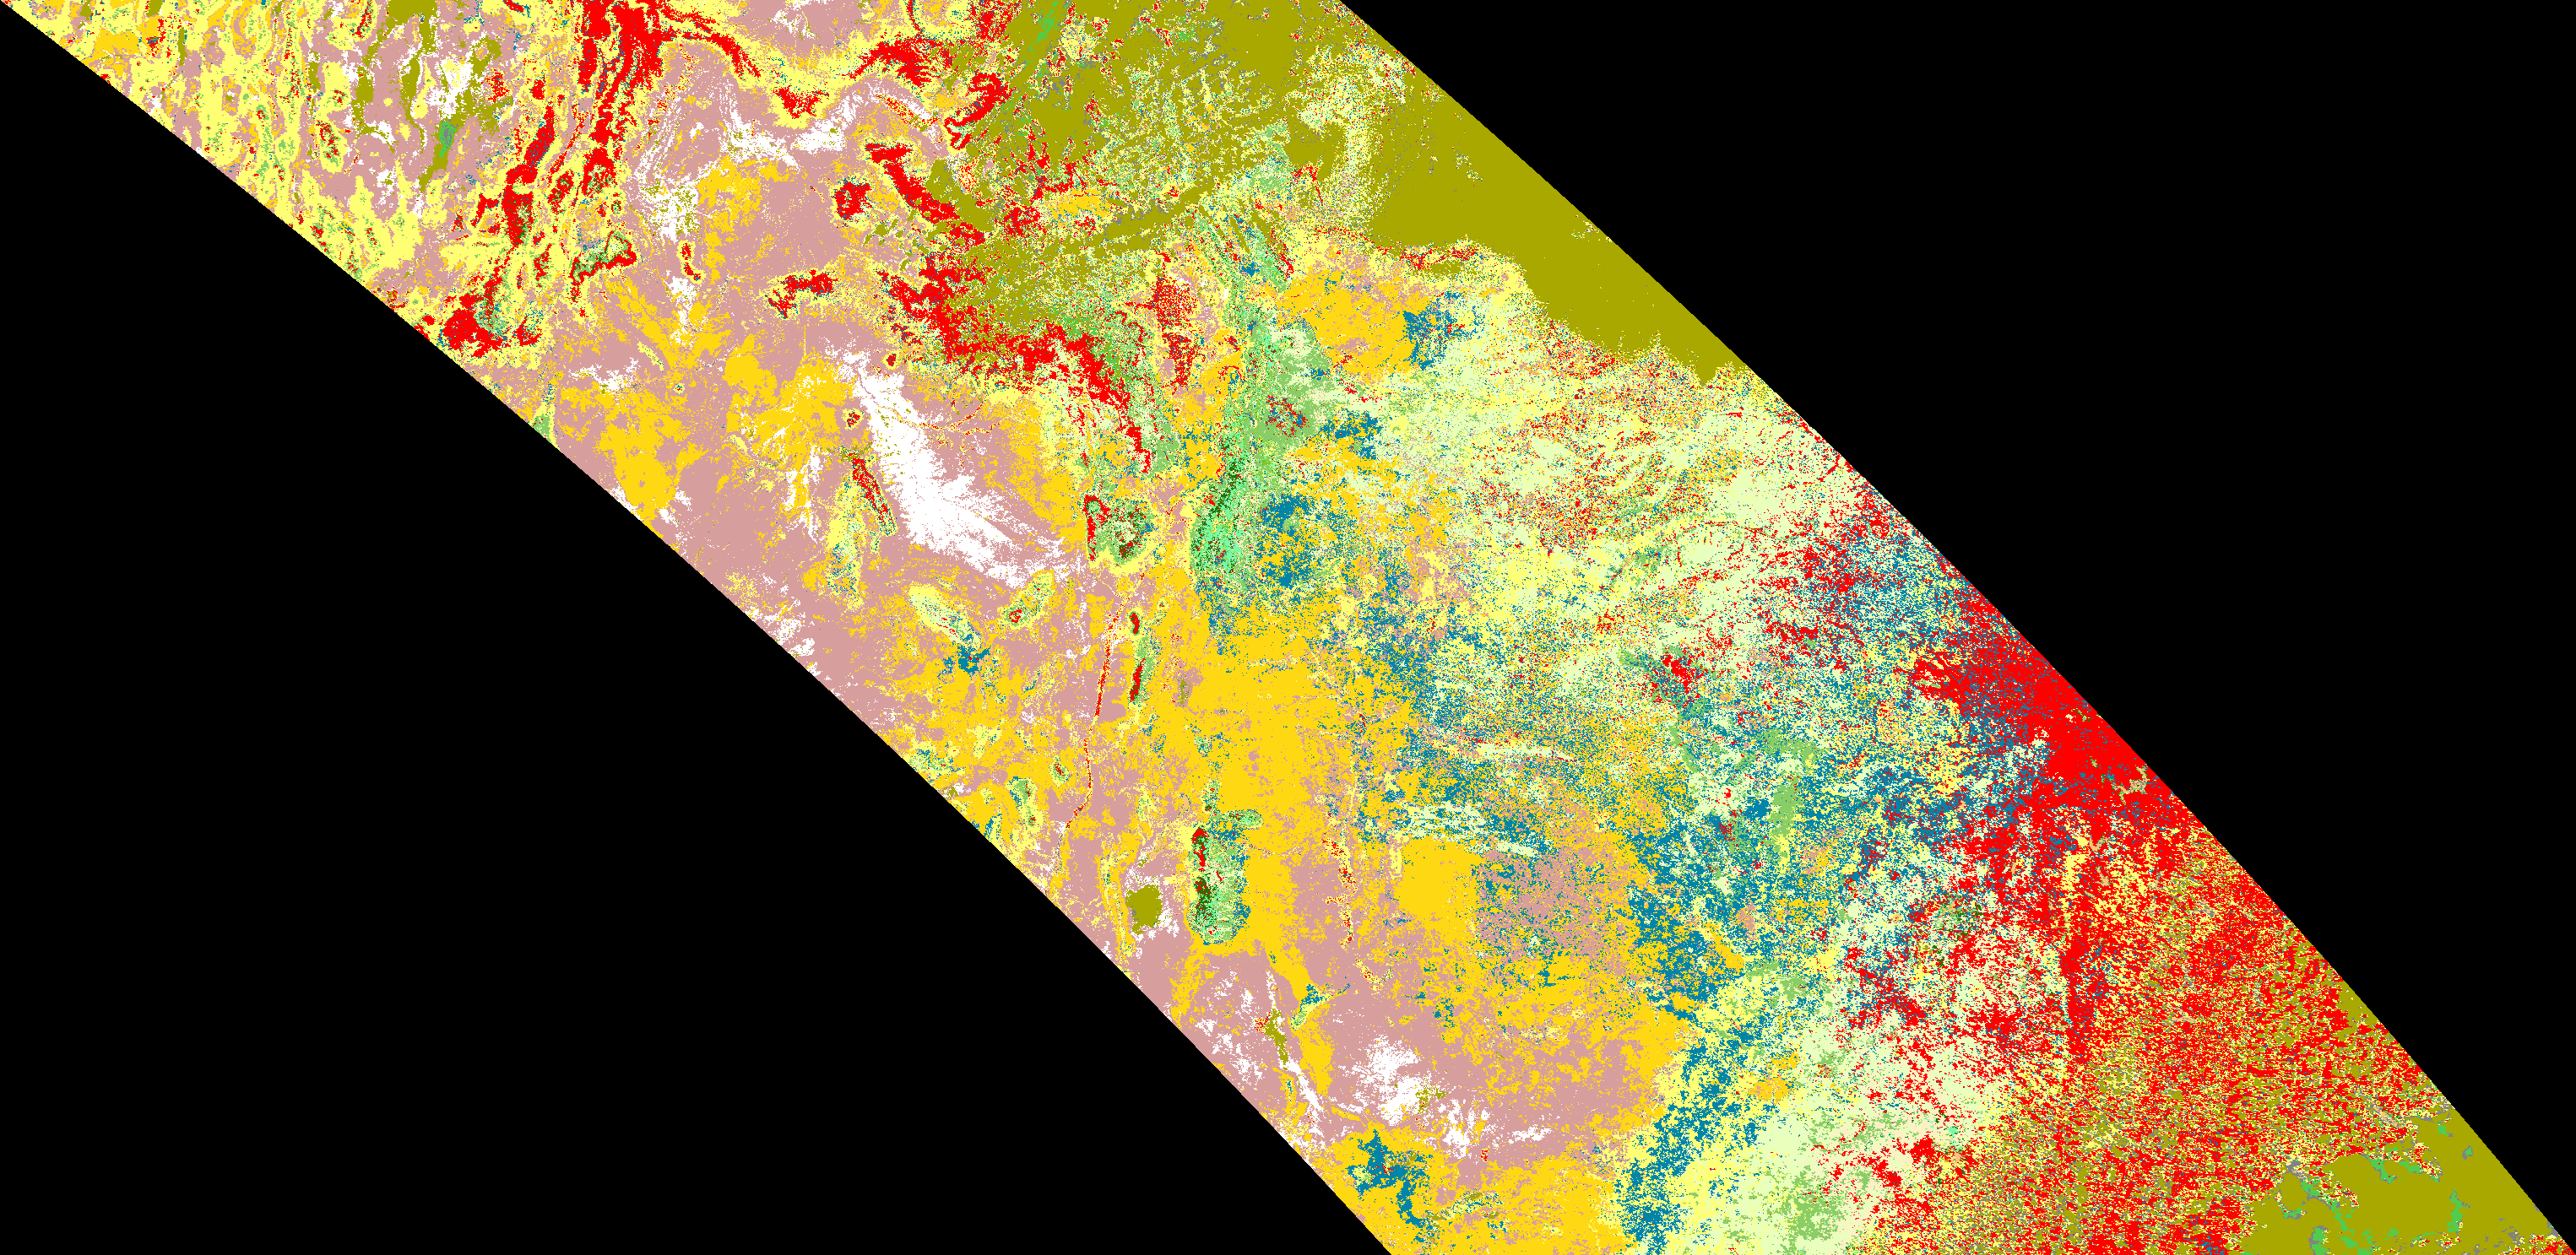
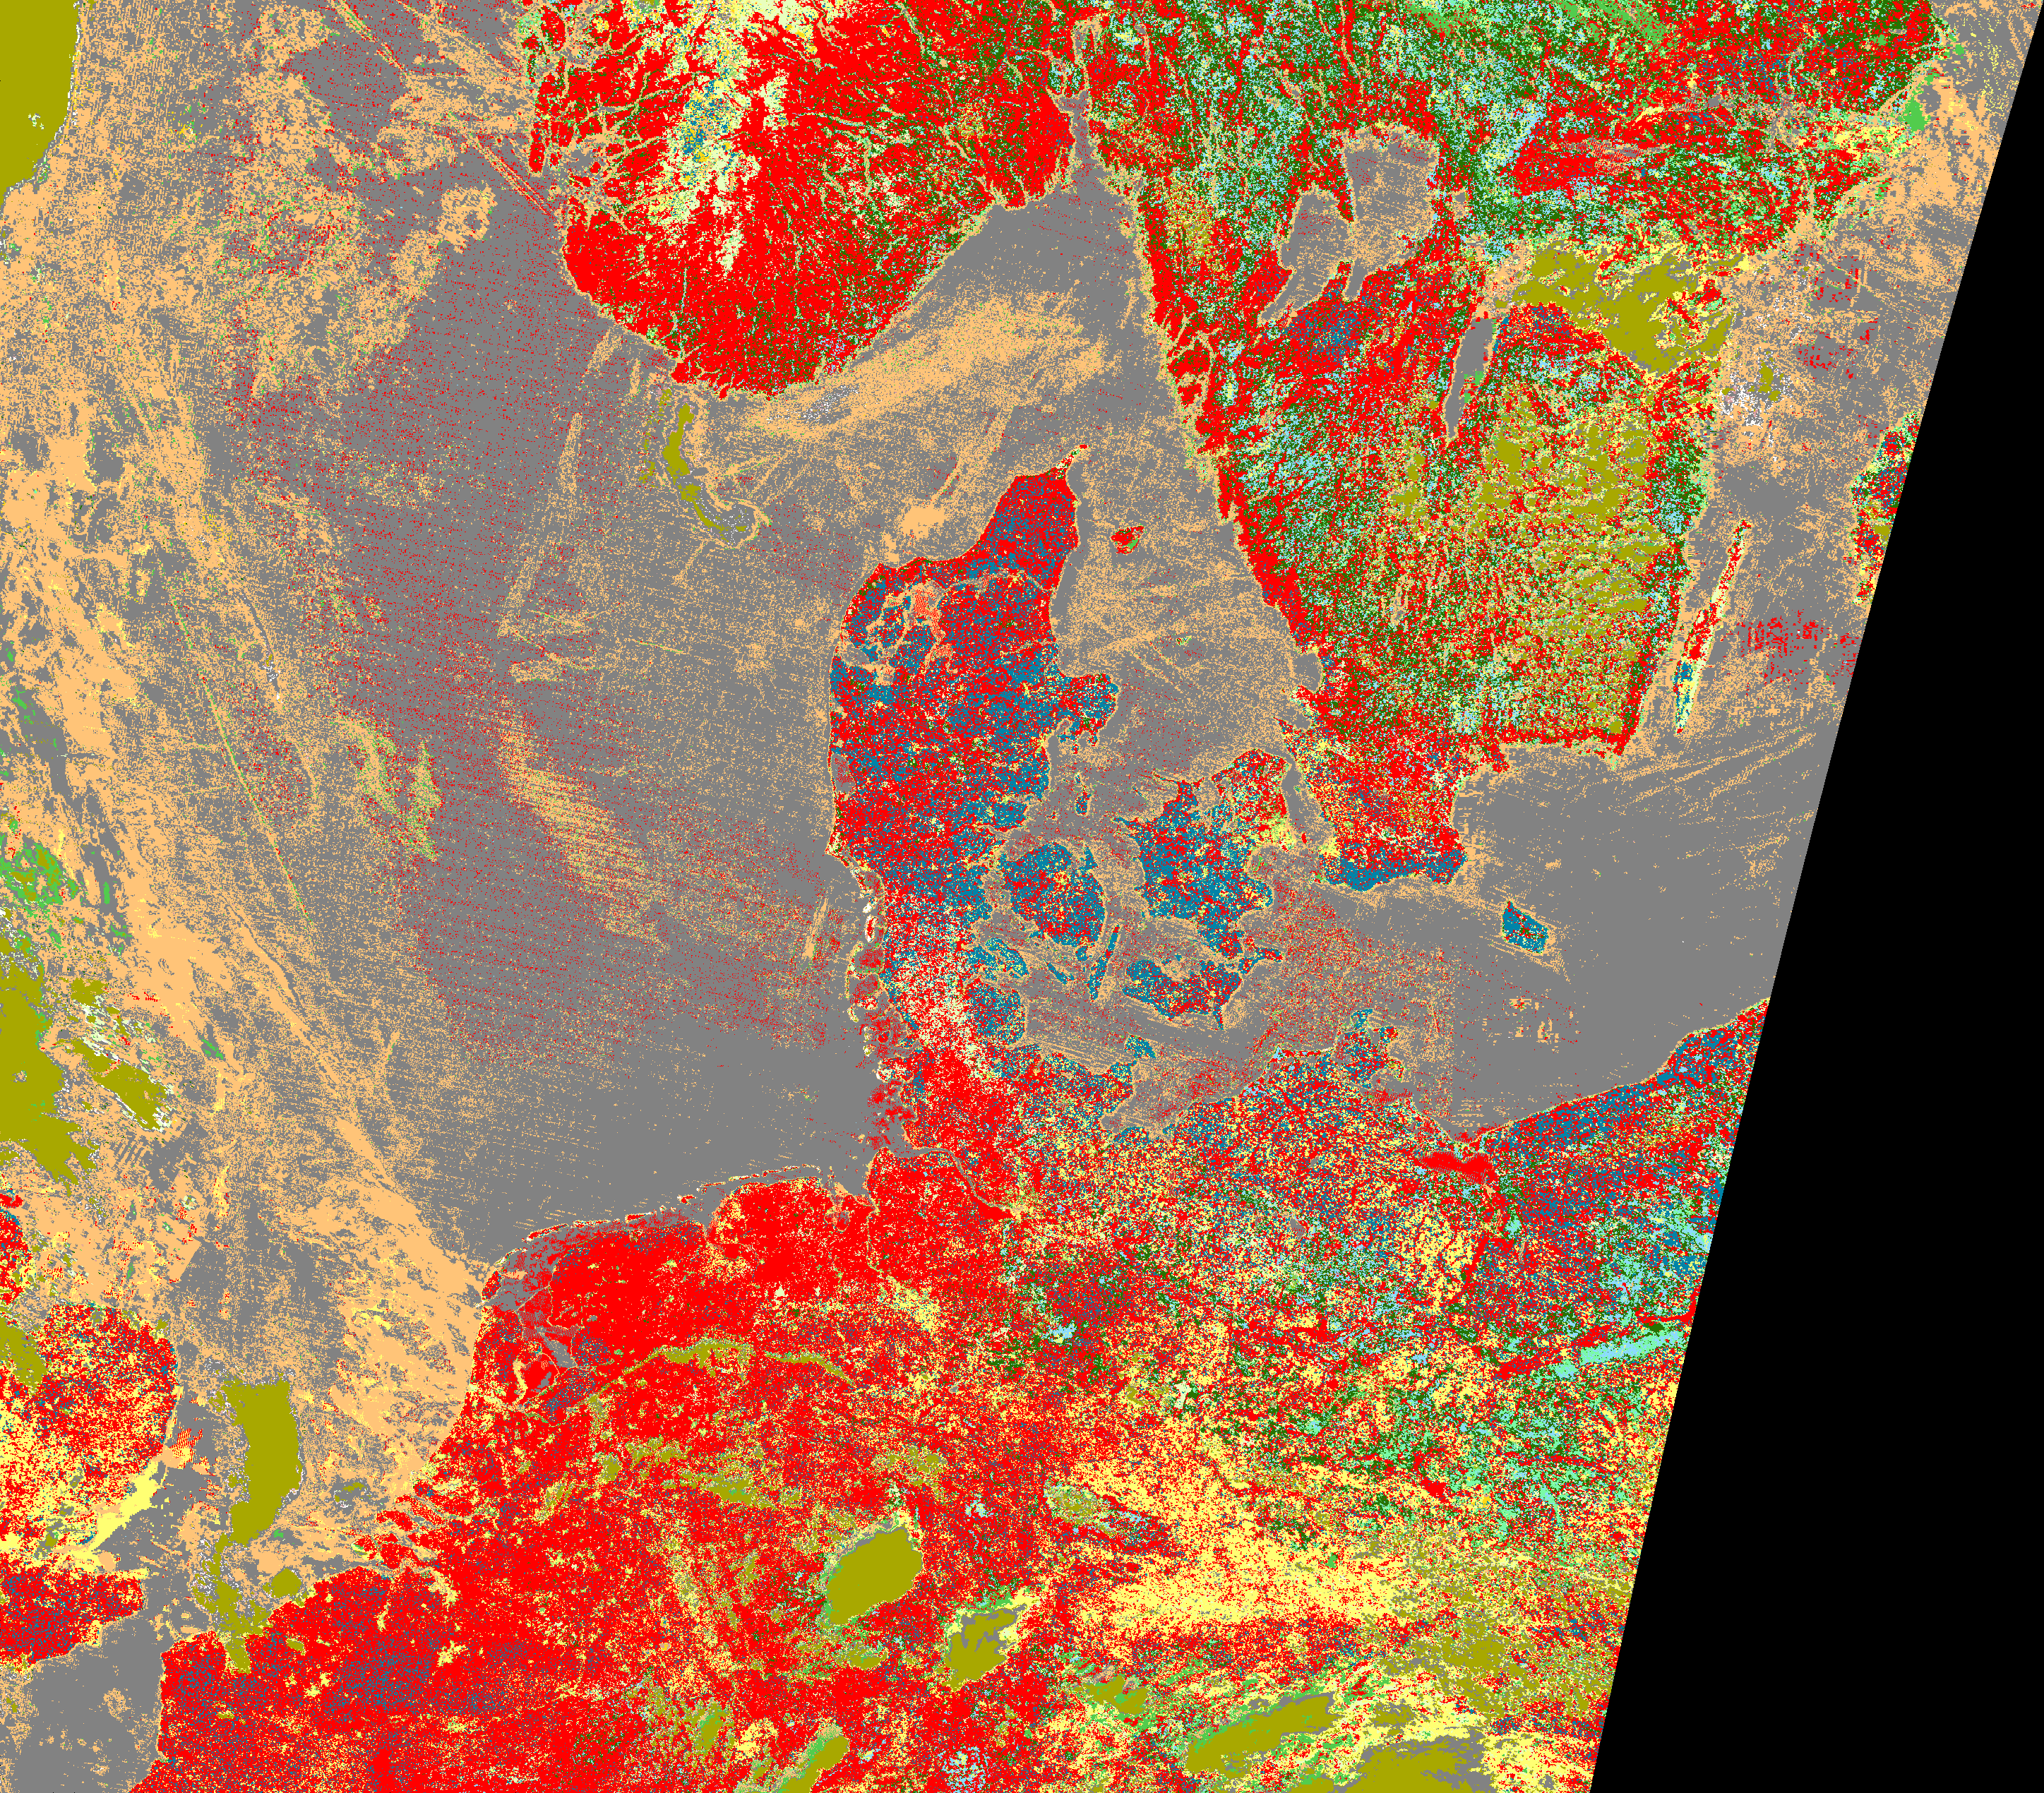
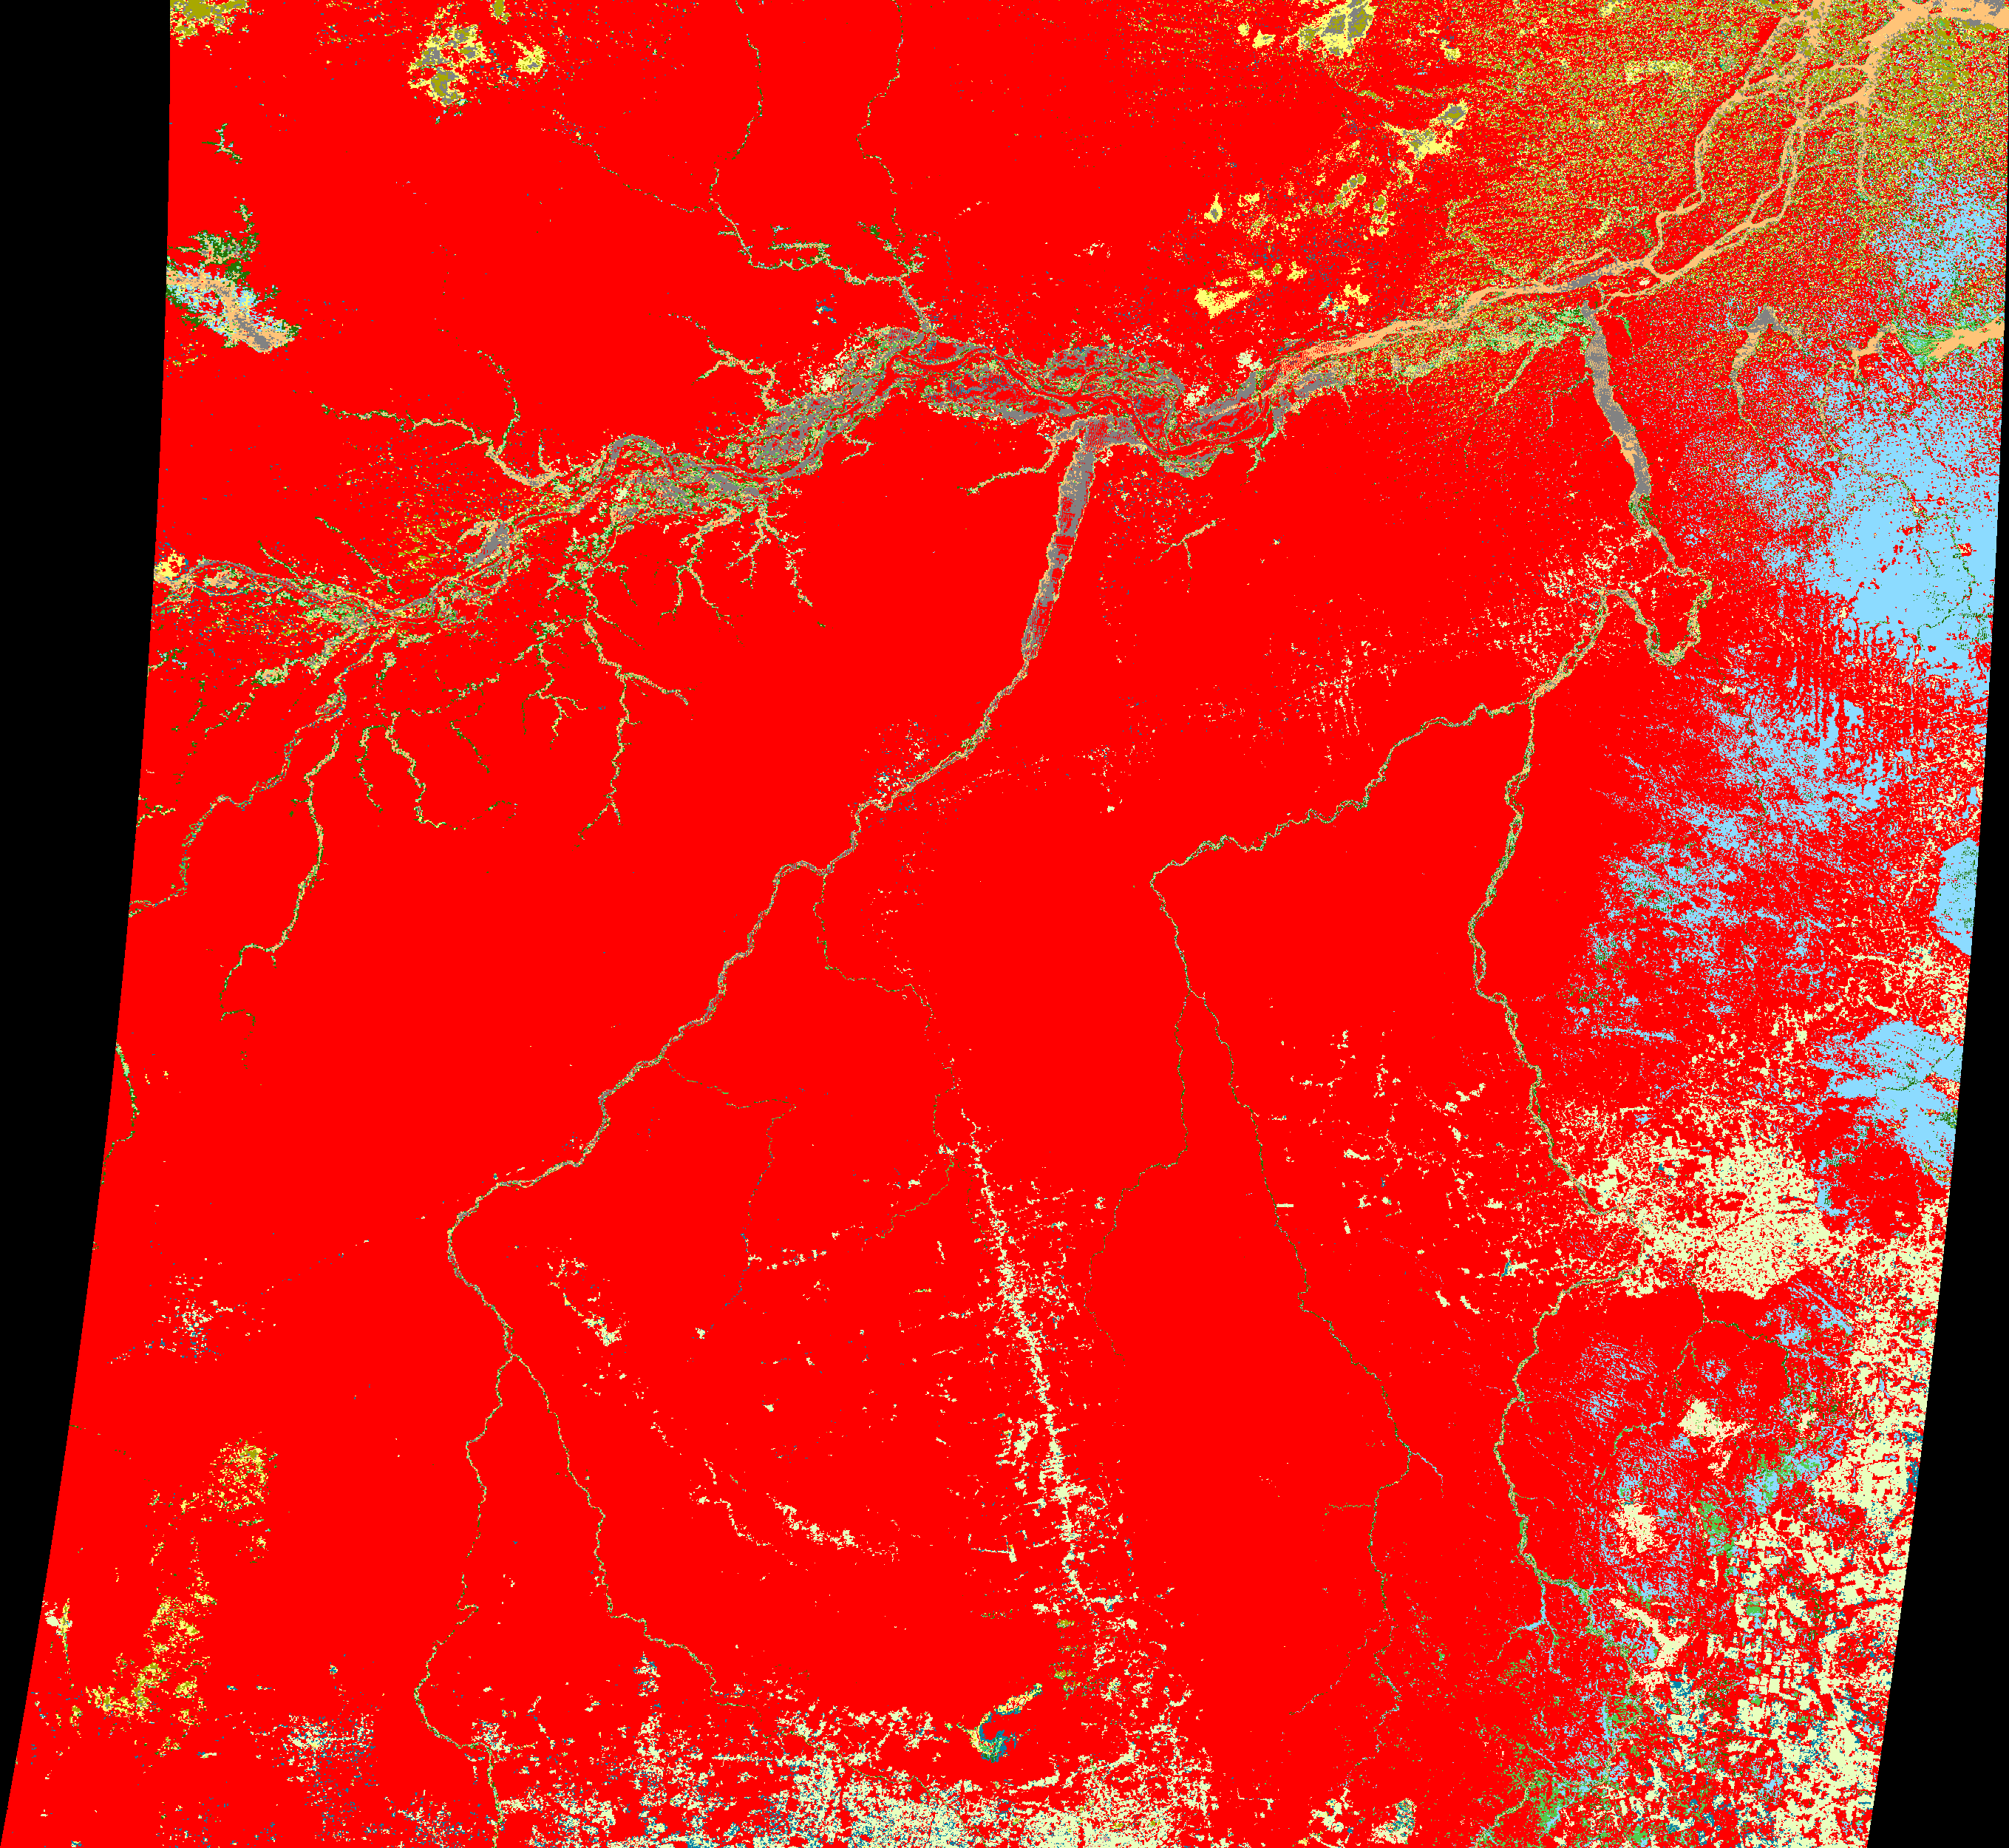

In [ ]:
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())
m

## 11. Explainable AI

SHAP values of a model’s output explain how features impact the output of the model.

In [ ]:
explainer = shap.TreeExplainer(classifier, data=X_test)
df_to_predict = X_test.sample(n = 1000)
shap_values = explainer.shap_values(df_to_predict)

100%|===================| 16998/17000 [15:01<00:00]       

In this plot, the impact of a feature on the classes is stacked to create the feature importance plot. Thus, if you created features in order to differentiate a particular class from the rest, that is the plot where you can see it. In other words, the summary plot for multiclass classification can show you what the machine managed to learn from the features.

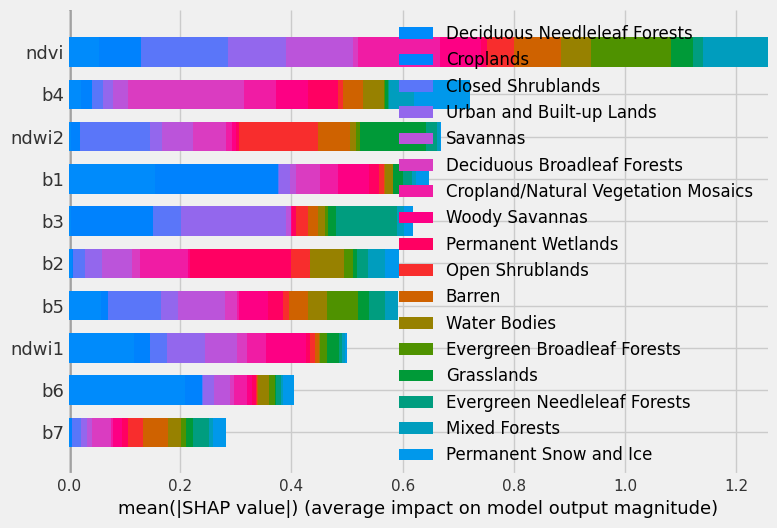

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, df_to_predict.values, plot_type="bar", class_names= class_names, feature_names = df_to_predict.columns)

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. You can see that the feature b1, being the least important feature, has low Shapley values.

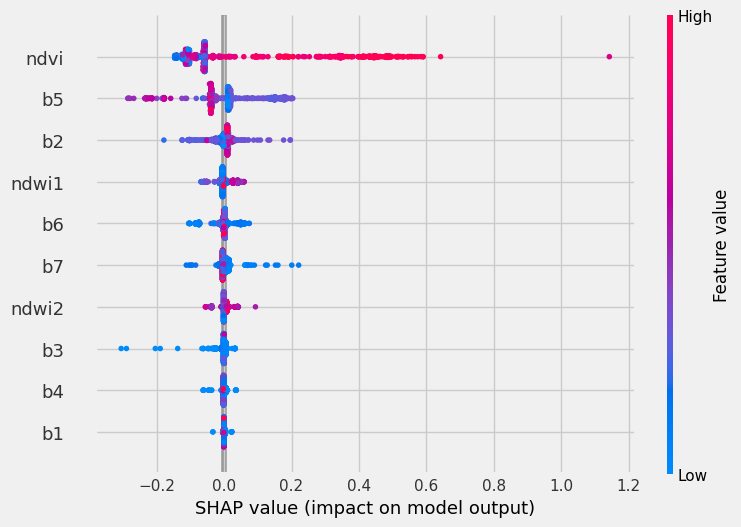

In [ ]:
shap.initjs()
shap.summary_plot(shap_values[1], df_to_predict.values, feature_names = df_to_predict.columns)

Force plot gives us the explainability of a single model prediction. In this plot, we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or a deep understanding of a particular case.

In [ ]:
i = 8
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][i], df_to_predict.values[i], feature_names = df_to_predict.columns)

Each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

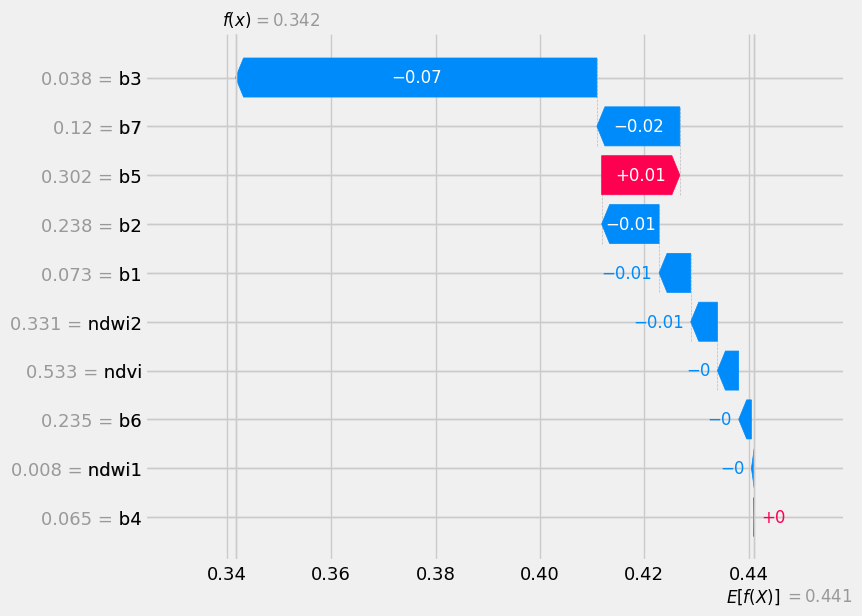

In [ ]:
row = 8
shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row],
                                              base_values=explainer.expected_value[0], data=X_test.iloc[row],
                                         feature_names=X_test.columns.tolist()))

## 12. Some Questions to Practice Before Final Assignment

- What can we do better to resample our training dataset and improve performance?
- What other model could benefit from this type of dataset?
- What other analysis would you add to this workflow based on your scientific problem?
- How can we make this process faster? (e.g. enable GPU) See this reference [XGBoost on GPUs](https://xgboost.readthedocs.io/en/stable/gpu/index.html)